<a href="https://colab.research.google.com/github/sphy1597/2022-1_ML/blob/main/%EA%B8%B0%EA%B3%84%ED%95%99%EC%8A%B5_%EA%B8%B0%EB%A7%90%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
os.environ['KAGGLE_USERNAME'] = 'tjsanseozjarhdrhk'
os.environ['KAGGLE_KEY'] = '895e90734d3759c98a5573a23ab38677'

!kaggel -h

/bin/bash: kaggel: command not found


In [4]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 59% 20.0M/34.1M [00:00<00:00, 209MB/s]
100% 34.1M/34.1M [00:00<00:00, 247MB/s]


In [5]:
!unzip -qq "/content/alzheimers-dataset-4-class-of-images.zip"
# Alzheimer_s Dataset으로 만들어진 폴더이름을 Alzheimer_Dataset으로 변경 필요
# 경로에 공백떄문

In [6]:
IMAGE_SIZE = [176,208]               # 원본 이미지 크기(176,208)
BATCH_SIZE = 5000
test_split_percent = .1       # 테스트 데이터 분리
validation_split_percent = .2 # 학습 확인을 위한 데이터 분리
zoom = [.99,1.01]             
bright_range = [.8,1.2]       
layers_unlocked = True        
lr = 0.01                   
batch = 20                   # batch사이즈
EPOCHS = 30                  # 에폭수


In [7]:
# 이미지 처리를 위한 imageDataGenerator
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,
                                                           brightness_range=bright_range,zoom_range=zoom,
                                                           data_format='channels_last',zca_whitening=False)

#학습 데이터
train_data_gen = train_dr.flow_from_directory(directory="/content/Alzheimer_Dataset/train",target_size=IMAGE_SIZE,
                                              batch_size=BATCH_SIZE)

# 테스트 데이터
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,zoom_range=[1,1],
                                                          data_format='channels_last') 
test_data_gen = test_dr.flow_from_directory(directory="/content/Alzheimer_Dataset/test",target_size=IMAGE_SIZE,batch_size=BATCH_SIZE,
                                           shuffle = False) # test data should not be shuffle

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [8]:
# 데이터 라벨링하여 업로드
train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

In [9]:
# 배열을 연결하여 데이터 결합
total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6279, 176, 208, 3)
(6279, 4)


In [10]:
initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# 학습 데이터에서 학습, 확인용 데이터 분리
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# 테스트 데이터에서 테스트, 확인용 데이터 분리
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4395, 176, 208, 3)
validation (628, 176, 208, 3)
test (1256, 176, 208, 3)


In [11]:
# 데이터 형태 확인
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4395, 176, 208, 3)
(4395, 4)
(628, 176, 208, 3)
(628, 4)
(1256, 176, 208, 3)
(1256, 4)


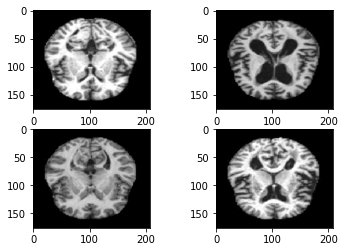

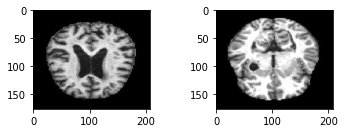

In [12]:
# 이미지 일부 확인
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [13]:
# 원본 모델에서 훈련된 것과 동일한 방식으로 이미지를 전처리합니다.
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


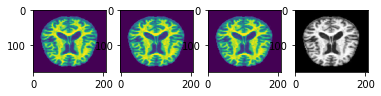

In [14]:
# 이미지 채널 확인
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

In [15]:
# 모델에 사용될 레이어 블럭
def conv_block(filters):
    block = tf.keras.Sequential([
        # 깊이별 분리 합성곱 사용 
        # 입력 채널별로 따로따로 공간 방향의 합성곱을 수행
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        #tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [16]:

#모델에 사용될 레이어 블럭
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        # Dense레이어 사용
        # 뉴런의 입력과 출력을 연결해주는 역할
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [17]:
# 최종 모델 빌드
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        #tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    return model

In [18]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
               tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='auc')]

    
    model.compile(
        optimizer='adam', # 옵티마이저 아담 사용
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [19]:
#학습 속도 조절 
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

# LearningRateScheduler는 epoch에 따라 학습률을 조정하는 callback입니다. 인자로 받는 schedule은 epoch index를 조정할 수 있는 function을 의미합니다.
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
#학습 
model_history = model.fit(train_data,train_labels,validation_data=(val_data,val_labels),
                             epochs=EPOCHS,batch_size=batch, shuffle=True)
scores = model.evaluate(train_data, train_labels)
print("Accuracy: %.2f%%" %(scores[1]*100))

Epoch 1/30
220/220 [==============================] - 32s 91ms/step - loss: 1.5805 - accuracy: 0.7108 - precision: 0.3683 - recall: 0.2196 - auc: 0.6122 - val_loss: 1.1042 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7861
Epoch 2/30
134/220 [=================>............] - ETA: 7s - loss: 1.1931 - accuracy: 0.7565 - precision: 0.5216 - recall: 0.3153 - auc: 0.7492

In [ ]:
#모델 정확도 출력
scores = model.evaluate(test_data, test_labels)
pred_labels = model.predict(test_data)